## The purpose of this script is simulate a lattice of triangles.

There are three kinds of triangles. 
Type 0 has no interaction and is a place keeper for an empty position.
Any type next to Type 0 is zero energy.
Type 1 is weakly repulsive with itself.
Type 2 is strongly repulsive with itself.
Type 1 and 2 is moderetly repulsive.
Energies are calculated along the sides of the triangles i.e. if two triangles share edges and not corners then the energy is calculated between them.


| e | 0 | 1 | 2 |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 1 | 0 | 3 | 6 |
| 2 | 0 | 6 | 9 |

The lattice for the triangles has periodic boundry conditions that are even on the sides but offset along the top and bottom so the lattice is trigonal in structure. 

Trial moves are made by randomly switching two particles, this switch in particles may also involve a change in orientation depending on which two particles are exhanged.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
def tabulate(center, neighbor):
    e = 0
    if center == 0 or neighbor == 0:
        e += 0
    elif center == 1 and neighbor == 1:
        e += 9
    elif center == 2 and neighbor == 1:
        e += 6
    elif center == 1 and neighbor == 2:
        e += 6
    elif center == 2 and neighbor == 2:
        e += 3
    return e

In [16]:
def pbc(A, B):
    #A is the row, B is the column
    if A >= len(lattice[:,0]):
        A -= len(lattice[:,0])
        B += (n-m)
        #print("Moving accross top periodic boundaries")
    if B >= len(lattice[0,:]):
        #print("Moving accross side periodic boundaries")
        B -= len(lattice[0,:])
    #print("Values are A = {}, B = {}".format(A,B))
    return A, B

In [17]:
def energy(sys):
    E = 0
    columns = len(lattice[:,0])
    rows = len(lattice[0,:])
    for i in range(columns):
        for j in range(rows):
            if lattice[i,j] == 1:
                a = sys[i,j]
                b = sys[pbc(i, j+1)]
                c = sys[pbc(i, j-1)]
                d = sys[pbc(i+1, j)]
                E += tabulate(a, b)
                E += tabulate(a, c)
                E += tabulate(a, d)
    return E

In [18]:
def trial_move(sys):
    temp = np.copy(sys)
    p1a = np.random.randint(0, len(sys[:,0]))
    p1b = np.random.randint(0, len(sys[0,:]))
    p2a = np.random.randint(0, len(sys[:,0]))
    p2b = np.random.randint(0, len(sys[0,:]))
    temp[p2a, p2b], temp[p1a, p1b] = temp[p1a, p1b], temp[p2a, p2b]
    return temp

In [19]:
def accept(de,kT): #implement detailed balance
    if np.exp(-de/kT) > np.random.rand():
        return True
    return False

In [20]:
def run(system, kT,steps): 
    e = np.array( int(steps)*[0])
    for trials in range(int(steps)):
        trial = trial_move(system)
        de = energy(trial)-energy(system)
        if accept(de,kT):
            system = np.copy(trial)
        e[trials] = energy(system)
        #if trials%100 == 0:
            #plot_system(system, trials)
    #plot_system(system, trials)
    return e,e.mean(), e.std()

In [21]:
def plot_color(x, y, system):
    type = system[x, y]
    if type == 0:
        color = '#cfd2d6'
    if type == 1:
        color = 'r'
    if type == 2:
        color = 'b'
    return color
def plot_orientation(x, y):
    orient = lattice[x,y]
    if orient == 0:
        marker = 'v'
    if orient == 1:
        marker = '^'
    return marker

In [22]:
def plot_system(system, trials):
    width = len(system[:,0])
    height = len(system[0,:])
    plt.figure(figsize = (8.1, 5.3))
    plt.axis('off')
    counter = m
    for x in range(width):
        counter -= 1
        for y in range(height):
            c = plot_color(x, y, system)
            marker = plot_orientation(x, y)
            if y <= counter:
                plt.scatter(y, -x, c=c, marker=marker, linewidths = 1.1, s = 650, alpha = 0.3)
                plt.scatter(y+n, -x, c=c, marker=marker, linewidths = 1.1, s = 650)
                #print(counter)
            if y > counter:
                plt.scatter(y, -x, c=c, marker=marker, linewidths = 1.1, s = 650)
    plt.savefig("MC_images/MC-{}.png".format(trials))
    plt.close()

In [23]:
def gen_structure(m,n):
    #n should be an odd number for correct lattice.
    #System needs to be a factor of 3
    lattice = np.array([1,0]*(m*n//2)+[1]*(m*n%2))
    a = len(lattice)//3 - 5
    b = len(lattice)//3 + 15
    c = len(lattice)//3 + len(lattice)%3-10
    system = np.array([0]*a+[1]*b+[2]*c)
    np.random.shuffle(system)
    system = system.reshape(m,n)
    lattice = lattice.reshape(m,n)
    for row in range(m):
        if row%2 == 1:
            lattice[row,:] = np.insert(lattice[row,:-1], 0, lattice[row, -1])
    return system, lattice

In [24]:
#m, n = 10, 18
#system, lattice = gen_structure(m, n)

In [25]:
#e, mean, std = run(system, 0.05, 10000)

In [39]:
m, n = 10, 18

temperatures = np.linspace(0.01, 5.5, 60)
eoft = []
eoftd =[]
colormap = plt.cm.brg
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(temperatures))])
for t in temperatures:
    ti = time.time()
    system, lattice = gen_structure(m, n)
    e, mean, std = run(system, t, 10000)
    eoft.append(np.mean(e[5000:]))
    eoftd.append(np.std(e[5000:]))
    #print("Sample run time: {}".format(time.time()-ti))
    plt.plot(np.arange(len(e))/1000., e, '.', label = t)

/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/evanmiller/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


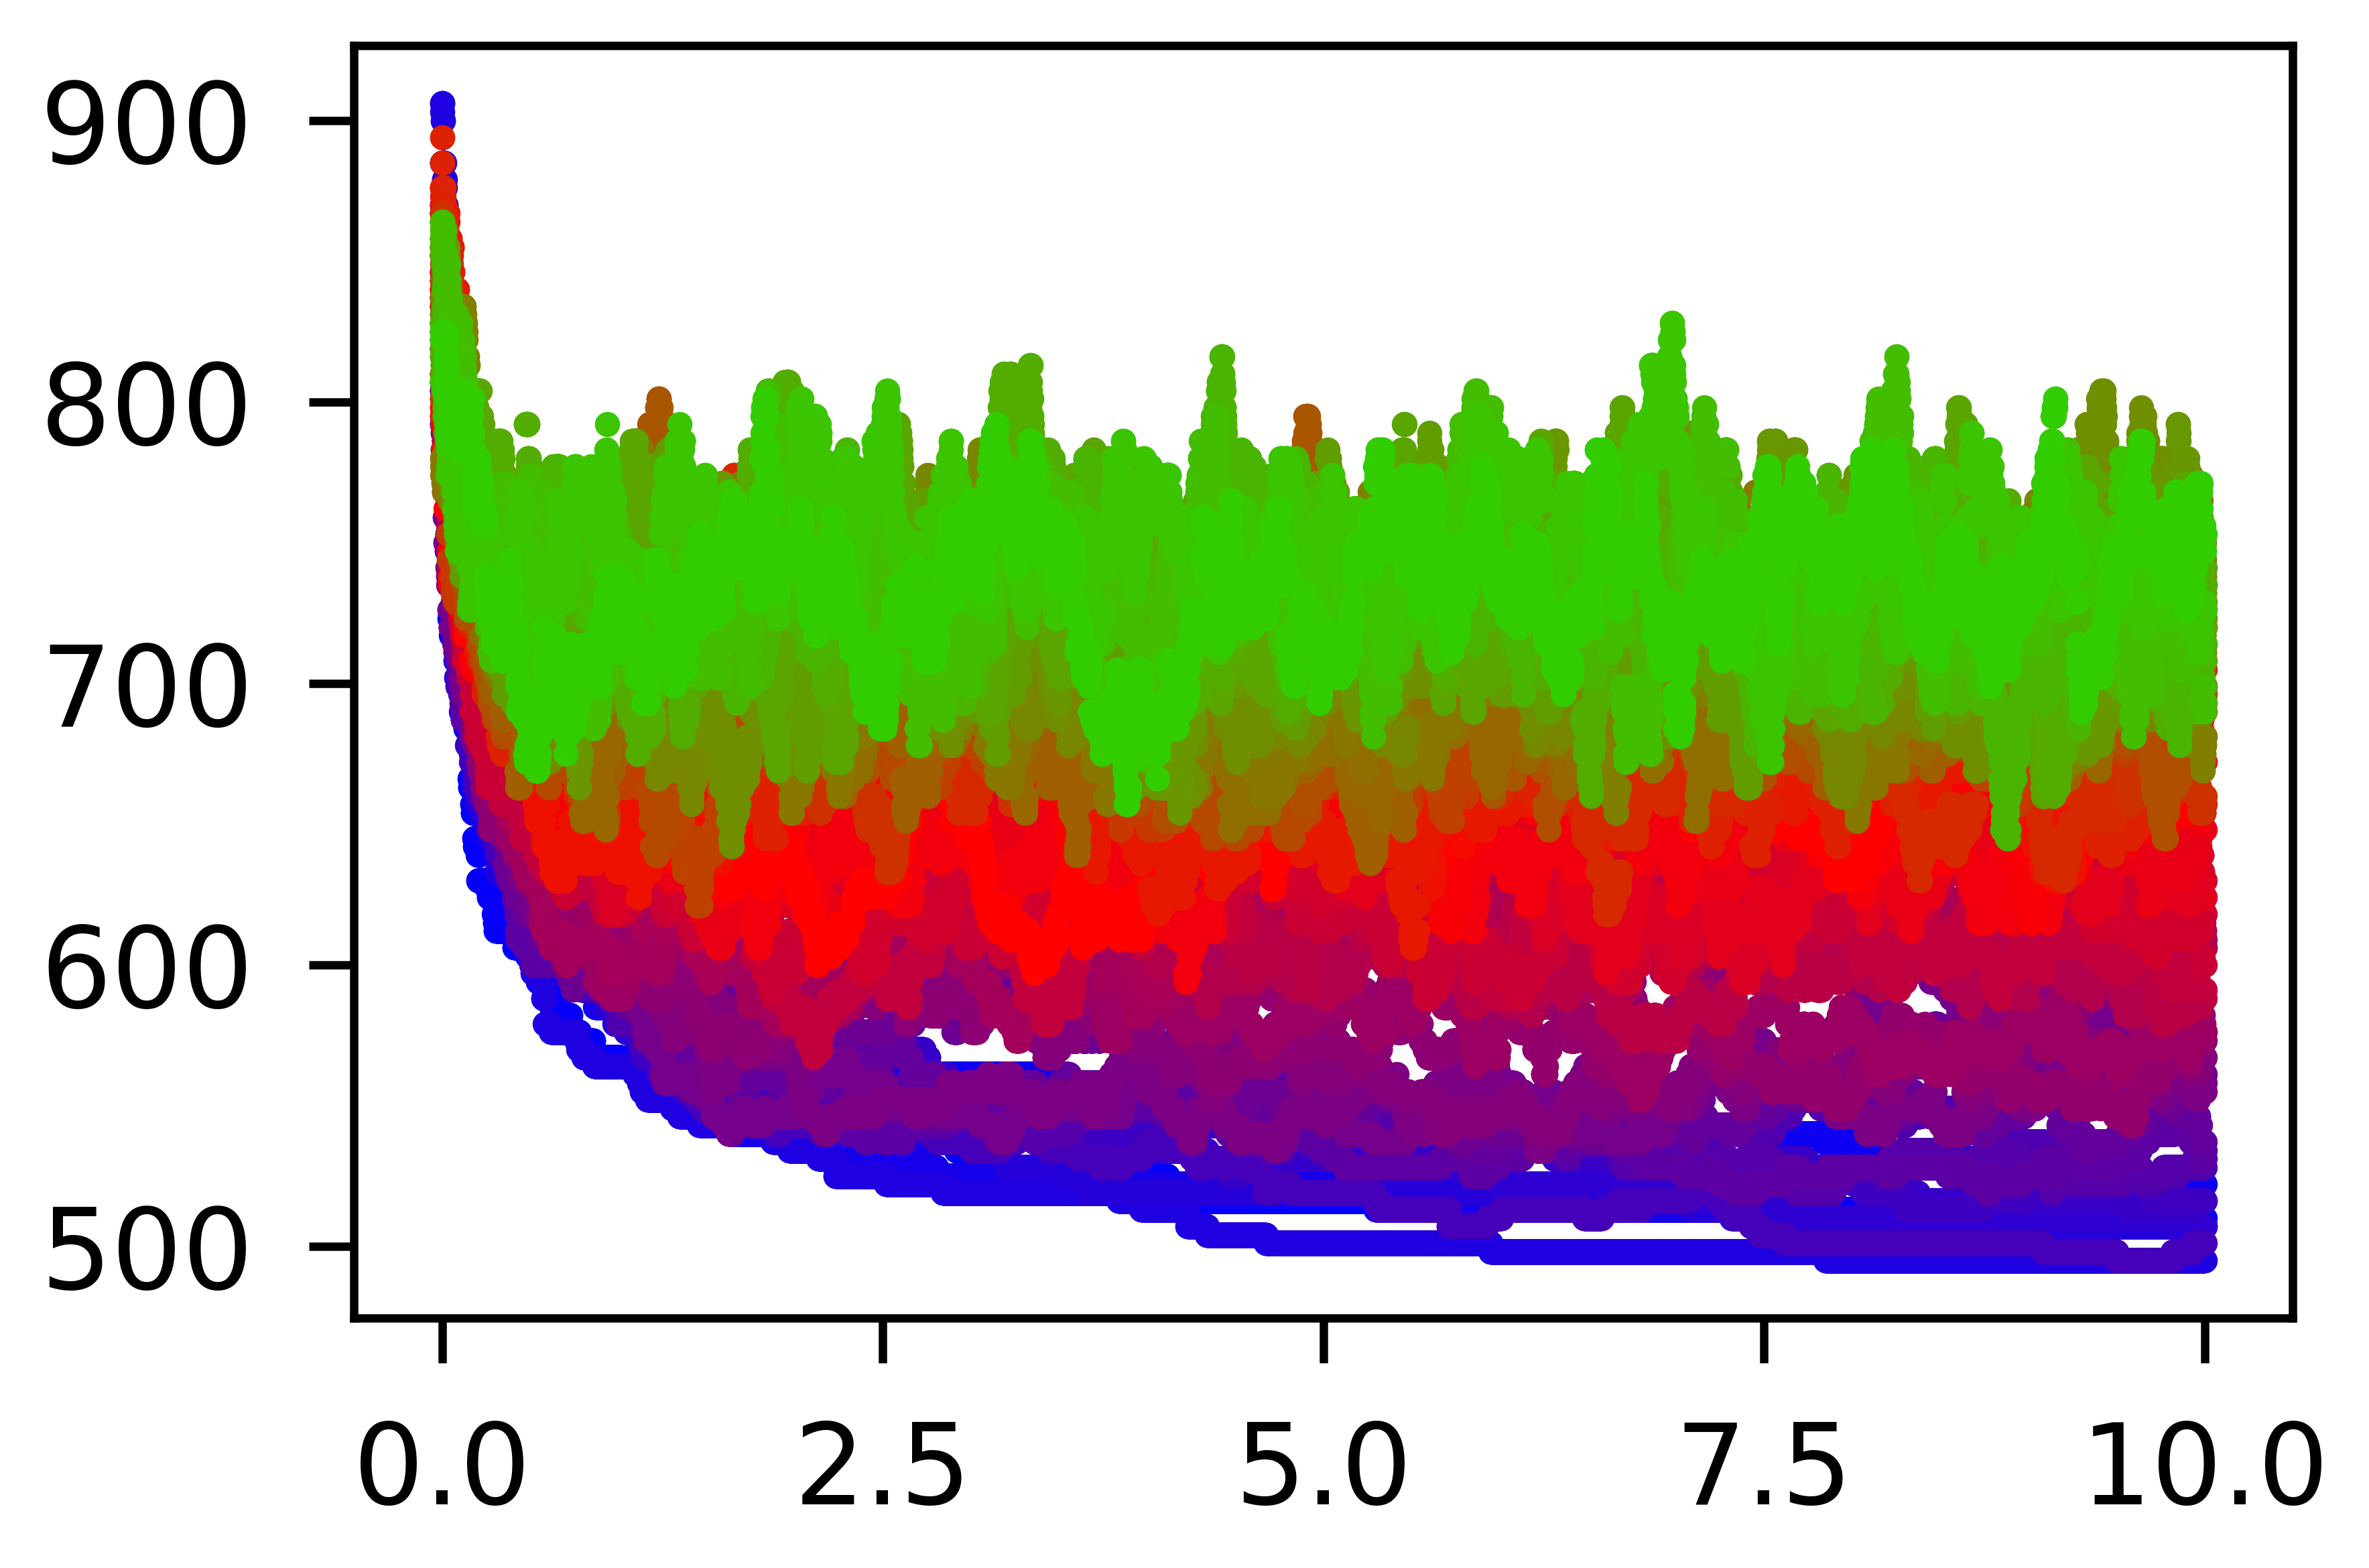

In [40]:
plt.show()

/home/evanmiller/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


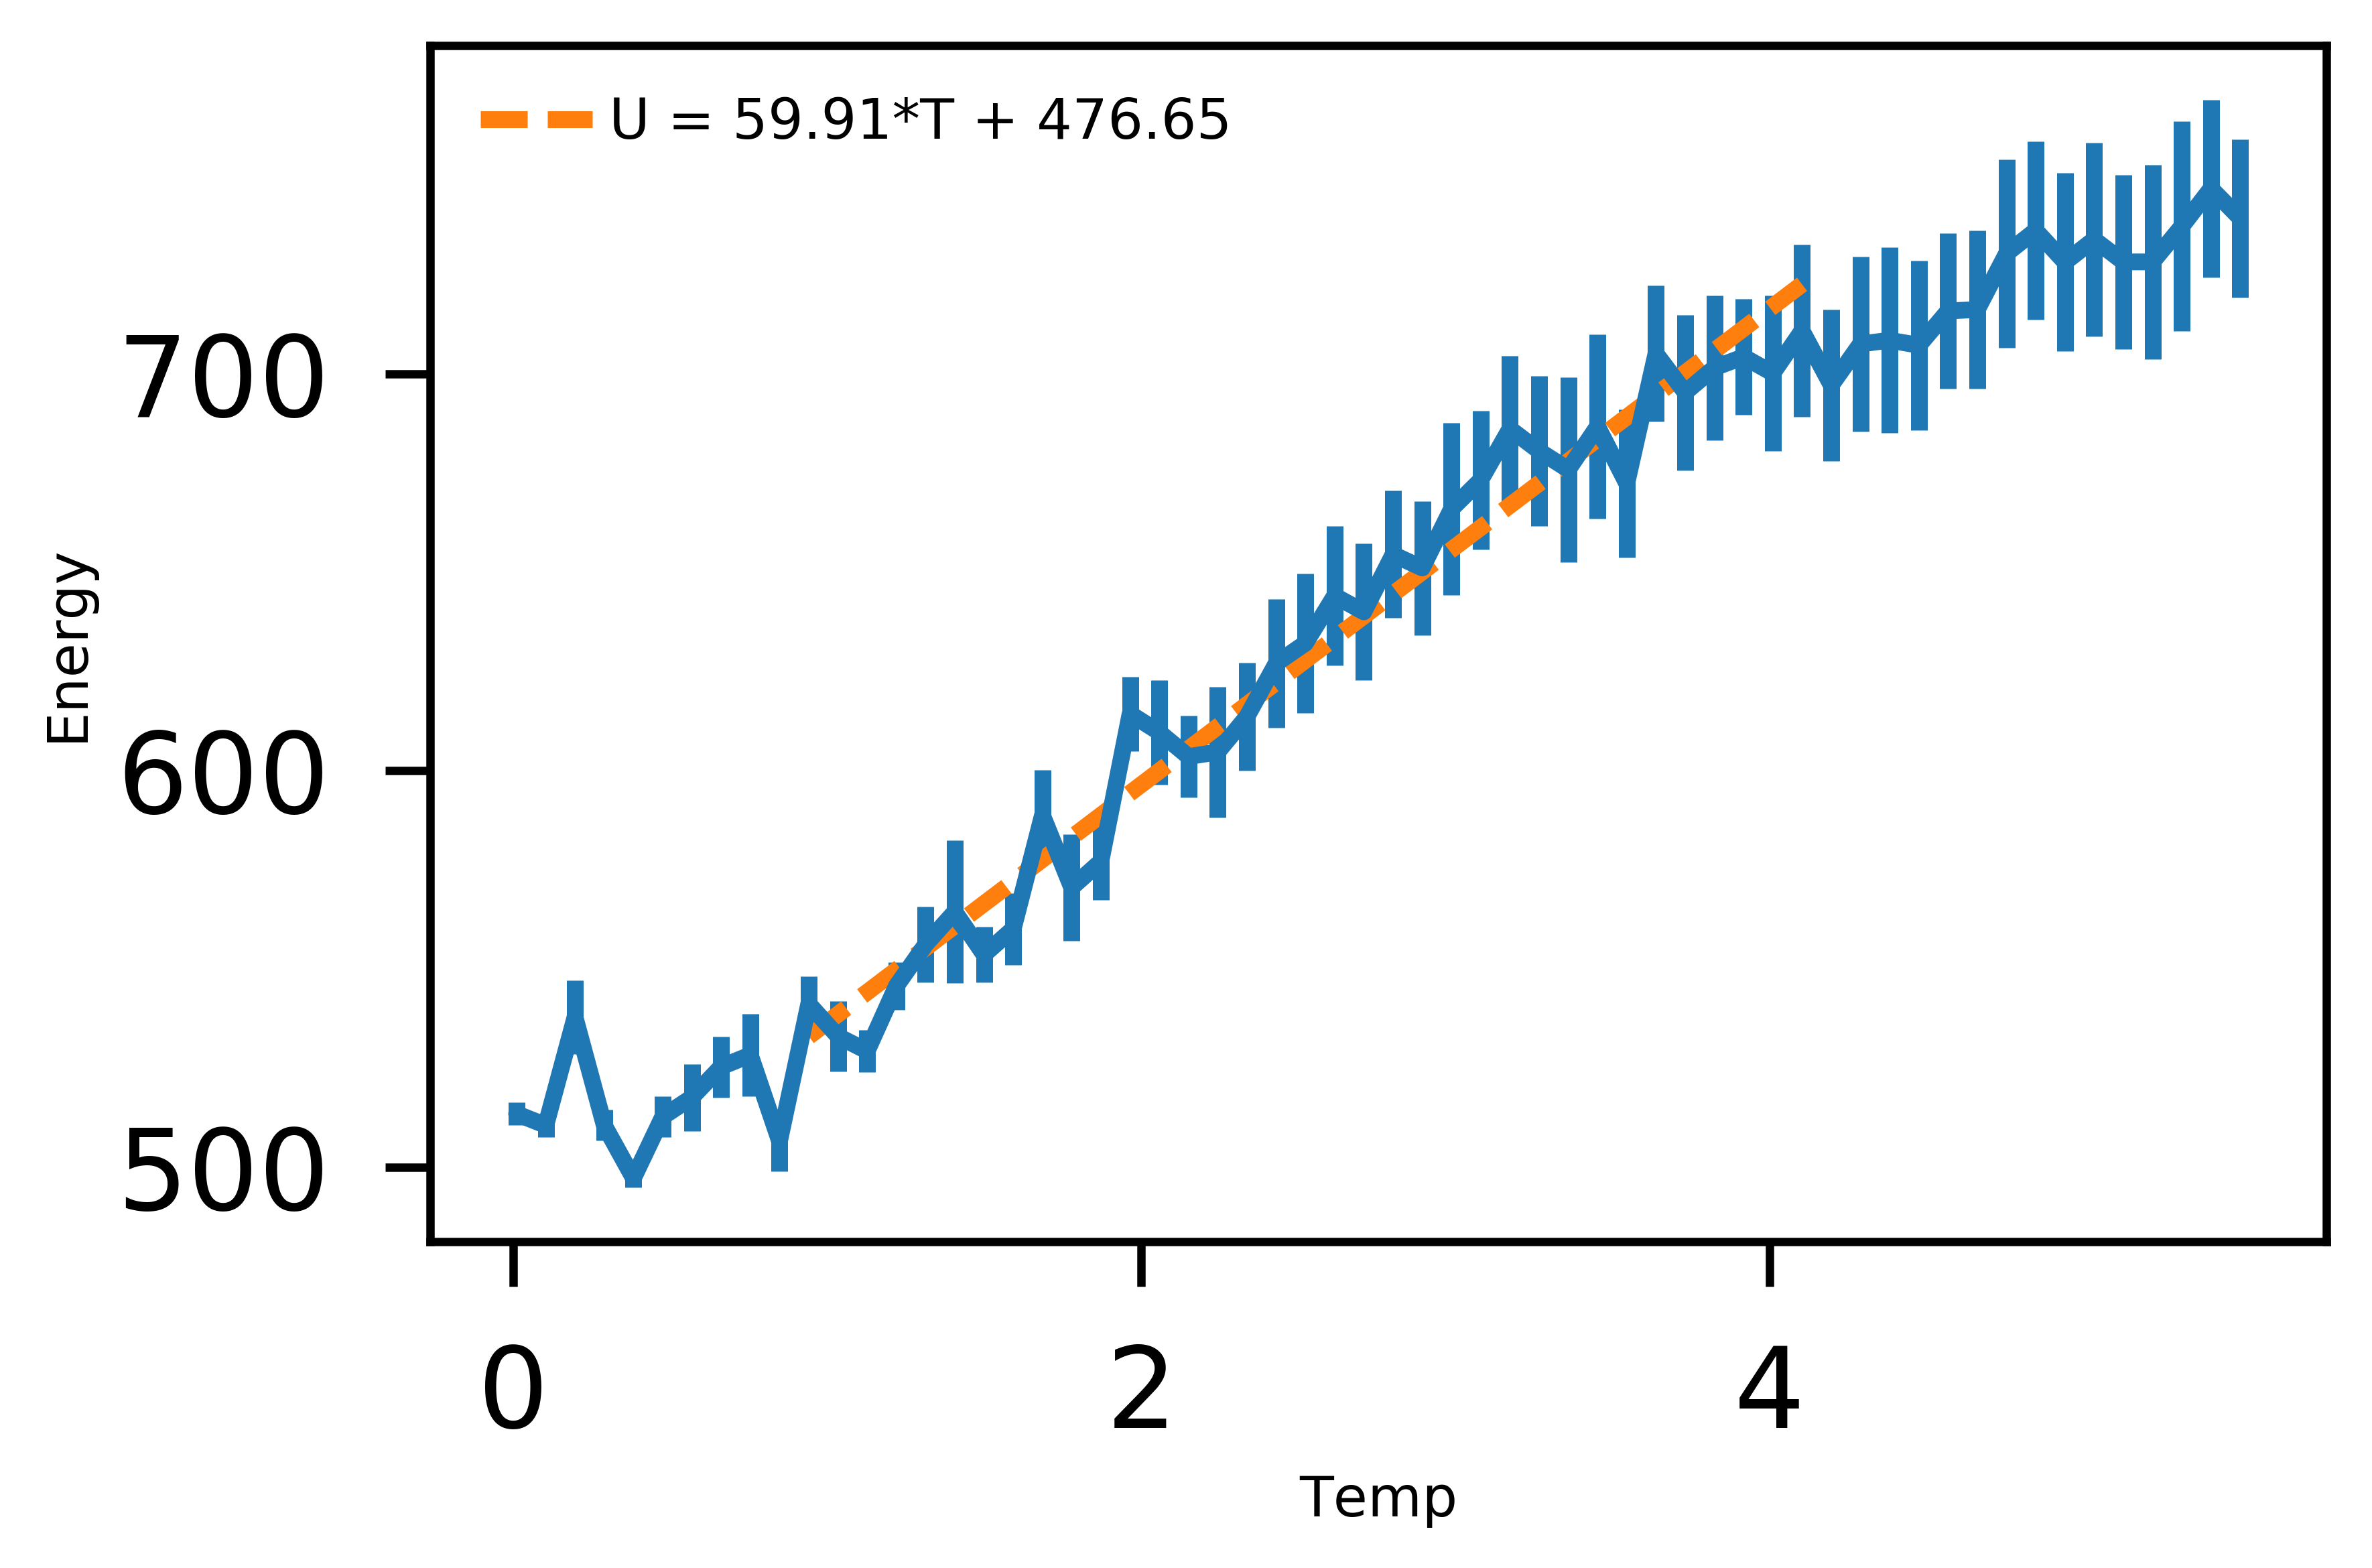

In [43]:
plt.errorbar(temperatures, eoft, yerr = eoftd)
plt.xlabel("Temp")
plt.ylabel("Energy")
z = np.polyfit(temperatures[10:-15], eoft[10:-15], 1)
plt.plot(temperatures[10:-15], temperatures[10:-15]*z[0]+z[1], '--', label = "U = {:.2f}*T + {:.2f}".format(z[0],z[1]))
plt.legend(loc = 'upper left')
plt.show()

# 3

**A**

For the two particle partition function Q, which is the sum of all quantum states *i* of the Boltzmann factor $e^{-E_{i}/k_{B}T}$. 
Since this is for an ideal gas, the Hamiltonian only depends on the kinetic energy.
Additionally, we know that the ideal, monoatomic gas has three degrees of freedom since it has no rotational or vibrational motion.
I assume that we look at the system in terms of the canonical ensemble, which we've used to look at ideal gasses in the past.

Therefore, we can use the equation (from homework 2):

\begin{equation}
Q(N,V,T) = \frac{1}{h^{3N}N!} \int dr e^{(- \beta H)} = \frac{V^N}{\lambda^{3N}N!}, \\
\lambda = \sqrt{2 \pi m / \beta},
\end{equation}

When the system only contains two particles, the system simplifies to

\begin{equation}
Q(N=2,V,T) = \frac{V^2}{\lambda^{6} * 2},
\end{equation}

which could be solved explicitely if the volume of the system, the temperature and the species of gas were known.

In our system, we will need four sites to calculate the partition function for two particles.
We have the center site, then the three adjoining sites. 
There are four possible energy levels in this system:
E = 0, when the center is blank.
E = 9, when two highly repulsive centers are next to eachother,
E = 6, when there is a highly repulsive and a weakly repulsive and
E = 3, when there are two weakly repulsive triangles together.

Therefore, we have the partition function when we assume k$_{B}$T = 1:

\begin{equation}
Z = e^{0}+e^{9}+e^{6}+e^{3},
\end{equation}

in the two particle system.

**B**

When the system contains N particles, we can't simplify for ideal gasses like we did above, to solve explicitely for the partition function. 
Like we did in the second homework, we can apply the relationship between the partition function and the Helmholtz free energy to determine the equation of state for a many-particle, ideal gas system to get the ideal gas law:

\begin{equation}
PV = NRT
\end{equation}

For our system with N particles, as N goes to infinity we have infinetly many possible energies. 
However, our system does have the benefit of always being an integer.

**C**

In our system we can calculate the total energy of the system with
\begin{equation}
U = \frac{1}{2}\sum\limits_{i}^{N}T_{i}(s1+s2+s3),
\end{equation}
where N is the number of sites and s1, s2 and s3 are the interactions of the triangle $T_{i}$ with sides 1, 2 and 3.
Our model is Ising model-esque, so it stands to reason that we should be able to find an equation of state for it.
However, finding an explicit model for the equation of state is a little more difficult since unlike the Ising model we have empty lattice positions.
Additionally, our particles are not binary +1 and -1s, rather the interactions vary based on the types of particles.

In our system we fail to see a sharp transition in the phase as indicated by the plot of energy vs temperature.
This could be due to the ratios of the particle types, since the ratios would determine how well the particles could segregate to minimize the energy i.e. there are is sufficient space for the highly repulsive particles to seperate without having to be near the weakly repulsive.

# 4

**A)** 

The systems at system size of 180 lattice sites and approximetly two thirds of the sites occupied requires approximetly 8,000 timesteps to reach equilibrium. 

**B)**

One of the limitations of this model is the periodic boundary conditions. With the system size currently being used (m,n = 10x18) the periodic boundary conditions are fairly easily calculated. The way the code is implemented now, the n value must be greater than that of m. This is due to the code's current inability to use off-set boundary conditions around the sides. Therefore, there are limits to the size of the system along with the dimensionality. Such issues could be overcome with additional codiing and some 'if-then' statements, but I feel would distract from the main point of the simulation.

**C)**

I do not have any idea if I could change the way the trial moves are conducted without creating concerns with breaking detail balance. I have implemented one method that helps with the computational efficiency. Rather than doubly counting the triangles by summing over all triangles, rather I only calculate the energy from the triangles that have the side facing the bottom. Such a calculation should be accurate while decreasing the number of calculations by half. It would be possible to speed up the calculation a little more by rather than calculating the energy of the whole system with each trial step I could caculate $dE$ as the energy local just to the switched particles.

# 5

**A)**

We should be able to calculate all the thermodynamic observables. The system in in the canonical ensemble. Since we have constant NVT, like the work we did in the first homework, we should be able to derive all the observables. 
This is easier said than done. 
Potential Energy is fairly easily calculated since it is the sum of the neighbor interactions, which are truncated after the first neighbor.
In terms of kinetic energy, we have two translational degrees of freedom, no vibrational degrees, but a quasi rotational state, since the triangles can change orientation.
However, I believe the kinetic energy can be neglected since kinetic energy is not used to calculate the energy of the system.
The internal energy and Hamiltonian are the sum of the potential energies:
\begin{equation}
H, U = \frac{1}{2}\sum\limits_{i}^{N}T_{i}(s1+s2+s3),
\end{equation}
where N is the number of sites, s1, s2 and s3 are the neigbors of triangle $T_{i}$ on sides 1, 2 and 3.
Since we can calculate the internal energy for a state, we can utilize the Maxwell relations to calculate other thermodynamic variables.

As an example, we can calculate the heat capacity C$_V$.
Since:
\begin{equation}
C_V = \Big(\frac{dU}{dT}\Big),
\end{equation}
we can determine C$_V$.
Unlike an ideal gas, where internal energy depends only on kinetic energy, here we have the opposite where there is no kinetic energy.
Here we take the average values of energy after equilibration to form the relation between T and U over the supsected range of the phase transition.
Therefore, we won't get an explicit solution or equation to calculate C$_V$, however we can get a numerical approximation:
\begin{equation}
C_V = \Big(\frac{dU}{dT}\Big) = dT(59.91T + 476.65) = 59.91
\end{equation}
We assume the relationship is linear, as a linear relationship gives a reasonable fit. 
Therefore, the $C_V$ is a constant: 59.91.

This doesn't surprise me too much, it stands to reason that if we are using statistical mechanics to build the system, we are able to now extract the statistically mechanical observables.

**B)**

In the simulation, aggregates form of the weakly repulsive triangles. This is due to the strongly repulsive triangles separating from eachother as much as possible and forcing the weakly repulsive triangles to aggregate.
At a temperature of T\* ~ 1 the aggregate begin to dissapear. 
However, the transition isn't a very sharp one.
The transition seems to finish around T* ~ 4, where the system is now completely random.

In other systems where there are only repulsive forces (especially those that are composed of only one type and have isotropic repulsive forces) such as colloidal systems, phase transitions are observed. 